In [2]:
import logging
import warnings
from tqdm import tqdm
from langdetect import detect
from ktrain import text 

from galvasr2.align.spark.align_lib import load_audio_id_text_id_mapping, load_transcripts

warnings.filterwarnings("ignore")

spark = SparkSession.builder \
                      .master("local[*]") \
                      .appName("NER") \
                      .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
                      .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")\
                      .config("spark.executor.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")\
                      .config("spark.driver.memory", "40g")\
                      .config("spark.executor.memory", "40g")\
                      .config("spark.rpc.askTimeout", "480s")\
                      .config("spark.executor.heartbeatInterval", "20000ms")\
                      .config("spark.eventLog.enabled", "true")\
                      .getOrCreate()

/install/miniconda3/envs/100k-hours-lingvo-3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/install/miniconda3/envs/100k-hours-lingvo-3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/install/miniconda3/envs/100k-hours-lingvo-3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/install/miniconda3/envs/100k-hours-lingvo-3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/install/miniconda3/envs/100k-hours-lingvo-3/lib/python3.7/importlib/_bootst

In [3]:
%%time
# spark.sparkContext.setLogLevel("INFO") # "ALL" for very verbose logging                                                                                                                                   
logging.getLogger("py4j").setLevel(logging.ERROR)
catalogue_df = load_audio_id_text_id_mapping(spark, "gs://the-peoples-speech-west-europe/archive_org/Mar_7_2021/CC_BY_SA_EXPANDED_LICENSES_FILTERED_ACCESS.jsonl.gz")
training_sample_rows = catalogue_df.collect()

# Comment this out to load everything. It might takes ~15 minute, in my experience, on an 8 core machine.
print(len(training_sample_rows))
init_rows = 60000
final_rows = 76627
training_sample_rows = training_sample_rows[init_rows:final_rows]
transcripts_df = load_transcripts(spark,
                                  "gs://the-peoples-speech-west-europe/archive_org/Mar_7_2021/CC_BY_SA_EXPANDED_LICENSES_FILTERED_ACCESS",
                                  training_sample_rows)
transcripts_pdf = transcripts_df.toPandas()

76627
CPU times: user 1.95 s, sys: 1.08 s, total: 3.03 s
Wall time: 1h 27min 56s


### Language detector

In [4]:
%%time
def detect_lan(row):
    try:
        return detect(row)
    except:
        return 'problem'
transcripts_pdf['language'] = transcripts_pdf['transcript'].apply(detect_lan)
transcripts_pdf.head()

CPU times: user 7min 20s, sys: 2.17 s, total: 7min 22s
Wall time: 7min 22s


,transcript,text_document_id,identifier,language
0,30 can order 30 can order 30 can order purse...,gov.house.ogr.dp.20090618.auto.srt,gov.house.ogr.dp.20090618,en
1,I'm next I'm next I'm next the House Rules C...,org.c-span.59184-1.auto.srt,org.c-span.59184-1,en
2,good morning good morning good morning diffi...,gov.house.ogr.20080311_hrs02RFM2154.auto.srt,gov.house.ogr.20080311_hrs02RFM2154,en
3,Rule rule. The meeting of the oh god. The mike...,hrs02FINCrisisRm1100_100113.asr.srt,hrs02FINCrisisRm1100_100113,en
4,right like like like but the government make...,gov.house.ogr.fw.20091118.auto.srt,gov.house.ogr.fw.20091118,en


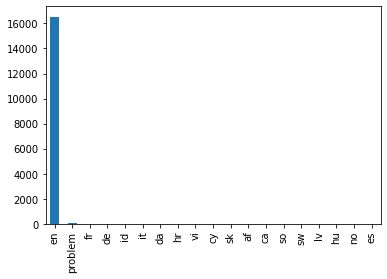

In [5]:
transcripts_pdf['language'].value_counts().plot(kind='bar')

In [6]:
transcripts_pdf['language'].value_counts()

en         16535
problem       27
fr            13
de             8
id             7
it             6
da             4
hr             4
vi             4
cy             3
sk             3
af             2
ca             2
so             2
sw             1
lv             1
hu             1
no             1
es             1
Name: language, dtype: int64

## Zero shot classification

In [8]:
%%time
zsl = text.ZeroShotClassifier()
labels=["Government", "Lecture", "Lesson", "Interview", "Politics", "Sermon", "Documentary", "Elections", "Sport",
        "Entertainment", "Healthy", "Artificial intelligence", "Financials", "Feed nutrition", "Radio", "Music",
        "South America", "North America", "Asia", "Europe", "Australia", "Africa", "Religion"]
def get_top_class(row):
    try:
        row = row[:1200]
        classification = zsl.predict(row, labels=labels, include_labels=True, batch_size=1, multilabel=False)
        classification.sort(key=lambda tup: tup[1])
        return classification[-1][0]
    except:
        return 'problem'
transcripts_pdf['classification'] = transcripts_pdf['transcript'].apply(get_top_class)
transcripts_pdf.head()

CPU times: user 10h 52min 56s, sys: 1h 23min 51s, total: 12h 16min 47s
Wall time: 7h 41min 10s


,transcript,text_document_id,identifier,language,classification
0,30 can order 30 can order 30 can order purse...,gov.house.ogr.dp.20090618.auto.srt,gov.house.ogr.dp.20090618,en,Government
1,I'm next I'm next I'm next the House Rules C...,org.c-span.59184-1.auto.srt,org.c-span.59184-1,en,Government
2,good morning good morning good morning diffi...,gov.house.ogr.20080311_hrs02RFM2154.auto.srt,gov.house.ogr.20080311_hrs02RFM2154,en,Government
3,Rule rule. The meeting of the oh god. The mike...,hrs02FINCrisisRm1100_100113.asr.srt,hrs02FINCrisisRm1100_100113,en,Financials
4,right like like like but the government make...,gov.house.ogr.fw.20091118.auto.srt,gov.house.ogr.fw.20091118,en,Government


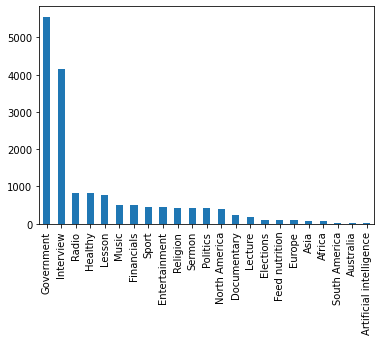

In [9]:
transcripts_pdf['classification'].value_counts().plot(kind='bar')

In [10]:
transcripts_pdf.to_csv('ZeroClassification4.csv', index=None)